In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shutil


import torch
import torch.nn as nn
from torch.utils.data import Dataset

from torch.optim.lr_scheduler import ReduceLROnPlateau,ExponentialLR


import torch.nn.functional as F
import torchvision.transforms as T 

from tqdm import tqdm

from torch_geometric.loader import DataLoader
from torch_geometric.transforms import NormalizeFeatures
from torch_geometric.nn import GCNConv,GraphConv, ChebConv,GATConv
from torch_geometric.nn.norm import BatchNorm 
from torch_geometric.nn.pool import global_mean_pool
from torch_geometric.data import Data
import torch_geometric as tg

import pyproj

PROJ = pyproj.Proj(proj='stere',  a=6378273, b=6378273, lon_0=-45, lat_0=90, lat_ts=90)

##Adding src path to get our code
import sys
sys.path.append('../src')
from ice_graph.ice_graph import Ice_graph
from utils.graph_utils import compute_normalization_batch
from utils.metrics import compute_metrics,velocity_norm, CustomIceLoss,velocity_angle
from models.training_utils import process_dataloader
from datasets.Ice_graph_dataset import Ice_graph_dataset
from models.GNNs import GCNN_2G

## Sea Ice ML - Training and data handling example

Here it is presented how to create custom graphs centered on neXTSIM elements, convert them into pytorch geometric data classes and train a simple GNN to predict trajectories.

Samples train: (7054,)


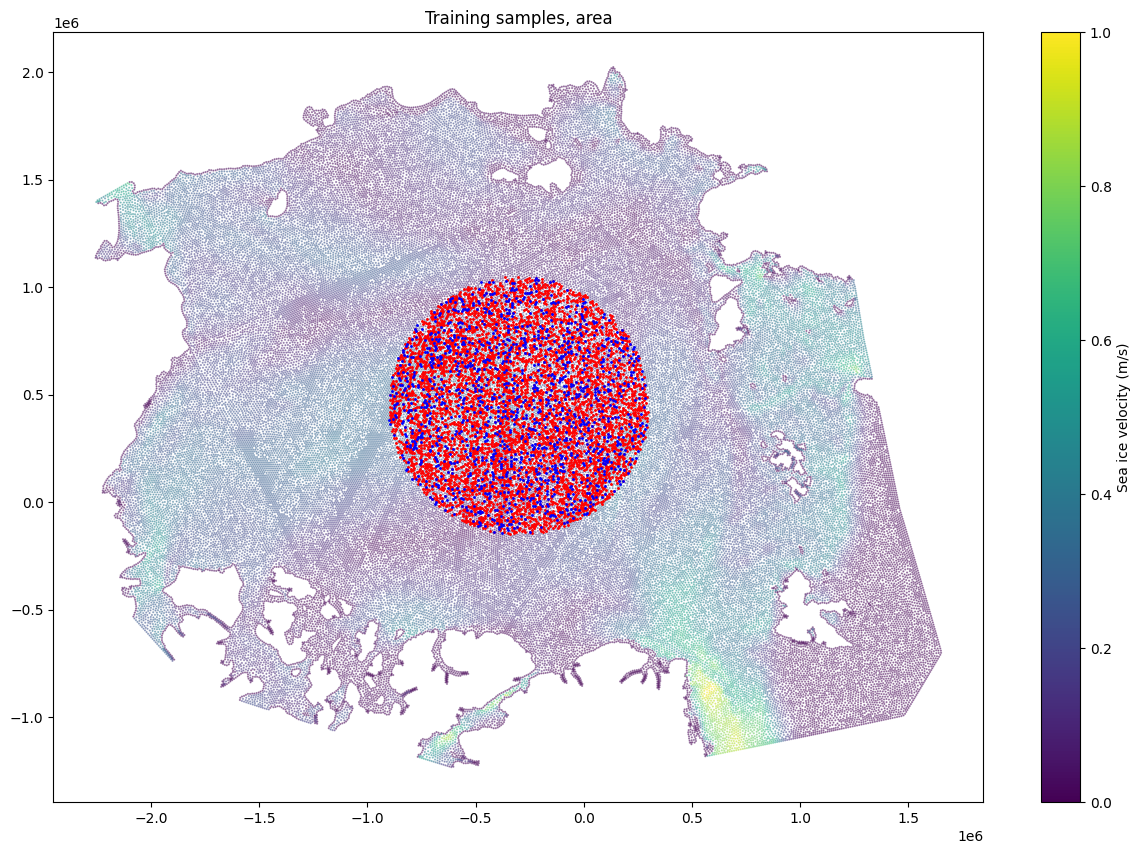

In [2]:
#Load the files (Note, you need to clone the repo first -- upper cells)
file_graphs = [dict(np.load(f'../example_data/{file}')) for file in sorted(os.listdir('../example_data')) if file[-3:]=='npz']
nextsim = Ice_graph(
    file_graphs,
    vertex_element_features =
        ['M_wind_x',
        'M_wind_y',
        'M_ocean_x',
        'M_ocean_y',
        'M_VT_x',
        'M_VT_y',
        'x',
        'y']
)

n_generations = 7054
predict_vel = True

radius = 600000 #meters
iterations = 1
time_index = 1 #index of element graph to fetch samples from
time_index_val = 12

validation_center = (-300000,450000)
training_center = (-300000,450000)

samples_train = nextsim.get_samples_area(training_center,radius,time_index=time_index,n_samples=n_generations,elements=False)
samples_val = nextsim.get_samples_area(validation_center,radius,time_index=time_index_val,n_samples=int(n_generations/5),elements=False)


selected_graph = nextsim.get_item(time_index,elements=False) 
#samples_train_idx = np.where(samples_train in selected_graph['i'])[0]
samples_train_idx = np.where(np.isin(selected_graph['i'],samples_train))[0]
samples_val_idx =  np.where(np.isin(selected_graph['i'],samples_val))[0]
print(f"Samples train: {samples_train.shape}")
#plot area defined by radius
plt.figure(figsize=(15,10))
vel_norm = np.sqrt(selected_graph['M_VT_x']**2 + selected_graph['M_VT_y']**2)
plt.scatter(selected_graph['x'],selected_graph['y'],c=vel_norm, s= 3 ,marker='.',linewidths=.7,alpha=.4)
plt.title("Training samples, area")
plt.scatter(selected_graph['x'][samples_train_idx],selected_graph['y'][samples_train_idx], color='red',s= 7 ,marker='.',linewidths=.7)
plt.scatter(selected_graph['x'][samples_val_idx],selected_graph['y'][samples_val_idx], color='blue',s= 7 ,marker='.',linewidths=.7)

plt.colorbar(label='Sea ice velocity (m/s)')


In [3]:
import importlib
%load_ext autoreload
%autoreload 2

remove_previous = False
save = True
nextsim.step = 3
neighbours = 6
fet = ['Concentration', 'Thickness', 'x', 'y']
#note = "_full_state"
note="fut_forcing"
save_dir = f'../data_graphs/{samples_train.shape[0]}_{int(radius/1000)}km_{time_index}tt_{time_index_val}tv_{neighbours}neigh_{nextsim.step}_step{note}'
print(save_dir)
if remove_previous:
    if os.path.exists(save_dir):
        #remove dir and contents
        shutil.rmtree(save_dir)


if not os.path.exists(save_dir):
    

    train_graph_list = []
    print("### Getting training samples ###\n")
    train_graph_list = nextsim.get_samples_graph(
        training_center,
        radius,
        [1,2,8,9,10,11,18,19],
        n_samples=n_generations,
        target_iter=iterations,
        e_features=fet,
        include_vertex=True,
        pred_velocity=predict_vel,
        n_neighbours=neighbours,
        future_forcing=True
    )

    print("### Getting validation samples ###\n")
    val_graph_list = nextsim.get_samples_graph(
        validation_center,
        radius,
        [4,5,12,13,14,20,21],
        n_samples=int(n_generations/5),
        target_iter=iterations,
        e_features=fet,
        include_vertex=True,
        pred_velocity=predict_vel,
        n_neighbours=neighbours,
        future_forcing=True
    )

    if save:
        print("### saving data ###\n")
        os.makedirs(save_dir, exist_ok=True)
        # Save training and validation graphs
        torch.save(train_graph_list, os.path.join(save_dir, 'training.pt'))
        torch.save(val_graph_list, os.path.join(save_dir, 'validation.pt'))

else:
    print("Data already exists")
    train_graph_list = torch.load(os.path.join(save_dir, 'training.pt'))
    val_graph_list = torch.load(os.path.join(save_dir, 'validation.pt'))



../data_graphs/7054_600km_1tt_12tv_6neigh_3_stepfut_forcing
Data already exists


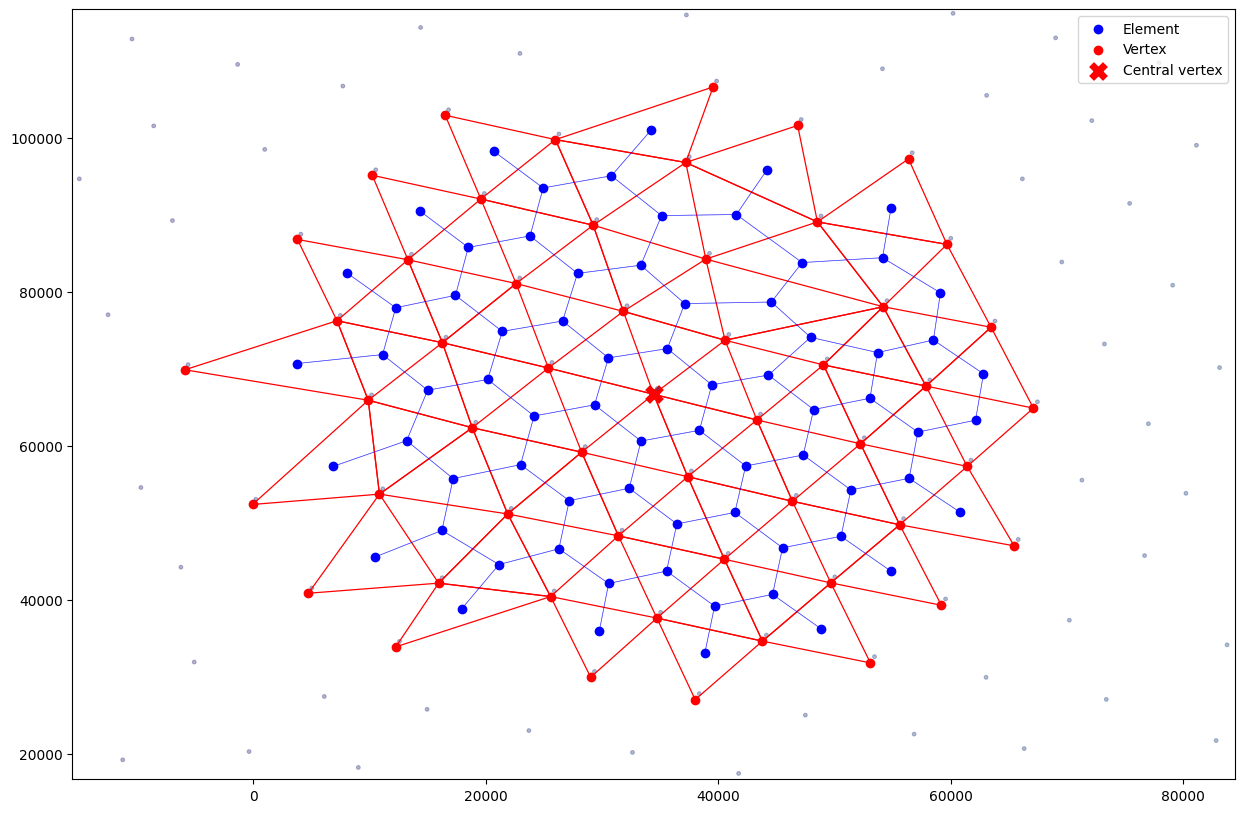

In [4]:
e_g,v_g = train_graph_list[9000]

plt.figure(figsize=(15,10))
central_pos = v_g.y[1]


for edge in v_g.edge_index.t():
    positions = np.array([v_g.pos.t()[edge[0]],v_g.pos.t()[edge[1]]])
    positions = positions.transpose()
    plt.plot(positions[0],positions[1],color='red',linewidth=.9)

for edge in e_g.edge_index.t():
    positions = np.array([e_g.pos.t()[edge[0]],e_g.pos.t()[edge[1]]])
    positions = positions.transpose()
    plt.plot(positions[0],positions[1],color='blue',linewidth=.5,alpha=.5)

plt.scatter(e_g.pos[0],e_g.pos[1],color='blue',label='Element')
plt.scatter(v_g.pos[0],v_g.pos[1],color='red',label='Vertex')

plt.scatter(central_pos[0],central_pos[1],marker='x', s=100, linewidth=5, c='red', label='Central vertex')
plt.scatter(selected_graph['x'],selected_graph['y'],c=vel_norm, s= 30 ,marker='.',linewidths=.7,alpha=.4)
plt.xlim(central_pos[0]-50000,central_pos[0]+50000)
plt.ylim(central_pos[1]-50000,central_pos[1]+50000)


plt.legend()

In [5]:
import torch.nn.init as init

from torch_geometric.nn import GCNConv,GraphConv, ChebConv,GATConv,TransformerConv


class GCNN_2G(nn.Module):
        
    def __init__(self, num_features1,num_features2, hidden_channels, output_size,dropout=0.1):
        super(GCNN_2G, self).__init__()
        channels_e, channels_v = hidden_channels

        if len(channels_v) != len(channels_e):
            raise ValueError("Different number of layers for vertices and elements")
        if len(channels_v) == 0:
            raise ValueError("At least one layer is needed")
        if channels_e[-1] != channels_v[-1]:
            raise ValueError("Last layer must have the same number of channels for vertices and elements")

        #self.bn1 = BatchNorm(num_features1)
        #self.bn2 = BatchNorm(num_features2)
        
        self.convs1 = nn.ModuleList([GATConv(num_features1, channels_e[0],dropout=dropout)])
        self.bn1 = nn.ModuleList([BatchNorm(channels_e[0])])

        for i in range(len(channels_e)-1):
            self.convs1.append(GATConv(channels_e[i], channels_e[i+1],dropout=dropout))
            self.bn1.append(BatchNorm(channels_e[i+1]))


        self.convs2 = nn.ModuleList([GATConv(num_features2, channels_v[0],dropout=dropout)])
        self.bn2 = nn.ModuleList([BatchNorm(channels_v[0])])
        for i in range(len(channels_v)-1):
            self.convs2.append(GATConv(channels_v[i], channels_v[i+1],dropout=dropout))
            self.bn2.append(BatchNorm(channels_v[i+1]))


        self.fc1 = nn.Linear(channels_v[-1], int(channels_v[-1]/2))
        self.fc2 = nn.Linear(int(channels_v[-1]/2), output_size)


    def forward(self,g1,g2):
        
        #g1.x = self.bn1(g1.x)
        #g2.x = self.bn2(g2.x)
        
        x1 = g1.x
        x2 = g2.x

        for conv,bn in zip(self.convs1,self.bn1):
            x1 = conv(x1, g1.edge_index,g1.edge_attr)
            x1 = bn(x1)
            x1 = F.relu(x1)

        for conv,bn in zip(self.convs2,self.bn2):
            x2 = conv(x2, g2.edge_index,g2.edge_attr)
            x2 = bn(x2)
            x2 = F.relu(x2)


        x1 = global_mean_pool(x1, g1.batch)      
        x2 = global_mean_pool(x2, g2.batch)# Shape: (n_node(across al batches),features) -> (batch size,features)


        #concatenate both outputs
        x = torch.stack([x1,x2],dim=0) #Shape: (2,batch size,features)
    
        x = torch.mean(x,dim=0) #Shape: (batch size,features)
      
        # Fully connected layer for the final output
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)       
        
        return x

In [4]:
import torch.nn.init as init

from torch_geometric.nn import GCNConv,GraphConv, ChebConv,GATConv,TransformerConv


class GCNN(nn.Module):
        
    def __init__(self, num_features1, hidden_channels, output_size,dropout=0.1):
        super(GCNN_2G, self).__init__()
        channels_e, channels_v = hidden_channels

        if len(channels_v) != len(channels_e):
            raise ValueError("Different number of layers for vertices and elements")
        if len(channels_v) == 0:
            raise ValueError("At least one layer is needed")
        if channels_e[-1] != channels_v[-1]:
            raise ValueError("Last layer must have the same number of channels for vertices and elements")

        
        self.convs1 = nn.ModuleList([ChebConv(num_features1, channels_e[0],dropout=dropout,K=1)])
        self.bn1 = nn.ModuleList([BatchNorm(channels_e[0])])
        for i in range(len(channels_e)-1):
            self.convs1.append(ChebConv(channels_e[i], channels_e[i+1],dropout=dropout,K=1))
            self.bn1.append(BatchNorm(channels_e[i+1]))


        self.fc = nn.Linear(channels_v[-1], output_size)

    def forward(self,g1):
                
        x1 = g1.x

        for conv,bn in zip(self.convs1,self.bn1):
            x1 = conv(x1, g1.edge_index,g1.edge_attr)
            x1 = bn(x1)
            x1 = F.relu(x1)     


        x1 = global_mean_pool(x1, g1.batch)      


        #concatenate both outputs
        x = x1
          
        # Fully connected layer for the final output
        x = self.fc(x)
       
        
        return x

In [6]:
from torch.utils.data import Dataset

#Dataset: serves to fetch graph data on dataloaders or training loop. Its a standard torch class to manage information, transfrom and iterate over it
class Ice_graph_dataset(Dataset):
    def __init__(self, data_list, normalize=True,z_score=True):
        super(Ice_graph_dataset, self).__init__()
        
        # List of graphs
        self.data_list = data_list
        self.normalize = normalize
        self.z_score = z_score
        if self.z_score:
            self.mean_e,self.mean_v,self.std_e,self.std_v = self.get_graphs_stats()
        else:
            self.min_e,self.min_v,self.max_e,self.max_v = self.get_graphs_stats()
            print(self.min_e,self.min_v,self.max_e,self.max_v)
            print(self.min_e.shape,self.min_v.shape,self.max_e.shape,self.max_v.shape)

    def __len__(self):
        return len(self.data_list)
    
    def get_graphs_stats(self):
        batch_size = len(self.data_list)
        train_dataloader = DataLoader(self.data_list, batch_size=batch_size)
        graphs = next(iter(train_dataloader))
        if self.z_score:
            std_e,std_v = graphs[0].x.std(dim=0) + 1e-6 , graphs[1].x.std(dim=0) + 1e-6
            mean_e,mean_v = graphs[0].x.mean(dim=0), graphs[1].x.mean(dim=0)

            return mean_e,mean_v,std_e,std_v
        else:
            min_e,min_v = graphs[0].x.min(dim=0)[0], graphs[1].x.min(dim=0)[0]
            max_e,max_v = graphs[0].x.max(dim=0)[0], graphs[1].x.max(dim=0)[0]

            return min_e,min_v,max_e,max_v
    
    def normalize_features(self, x,element=None):

        if self.z_score and element:
            return (x - self.mean_e)/self.std_e
        elif self.z_score and not element:
            return (x - self.mean_v)/self.std_v
        elif not self.z_score and element:
            return (x - self.min_e)/(self.max_e-self.min_e)
        else:
            return (x - self.min_v)/(self.max_v-self.min_v)

    def __getitem__(self, idx):
        data = self.data_list[idx]

        if self.normalize:
            data[0].x = self.normalize_features(data[0].x,element=True)
            data[1].x = self.normalize_features(data[1].x,element=False)

        return data
    




"""
class CustomIceLoss(nn.Module):
    def __init__(self, A=1, B=0, C=0, step=1, d_time=3600):
        super(CustomIceLoss, self).__init__()
        self.mae = nn.L1Loss()
        self.A = A
        self.B = B
        self.C = C
        self.step = step
        self.d_time = d_time

    def normalize(self, x):
        # Normalize tensor x along dimension 1
        return x / x.norm(p=2, dim=1).unsqueeze(1)

    def velocity_angle(self, real_v, v_pred):
        v_pred_norm = self.normalize(v_pred)
        real_v_norm = self.normalize(real_v)
        dot = torch.clamp((v_pred_norm * real_v_norm).sum(dim=1), min=-0.99, max=0.99)
        return torch.acos(dot).mean()

    def forward(self, v_pred, v_real, init_coords):
        position_pred = v_pred * self.step * self.d_time + init_coords
        position_real = v_real * self.step * self.d_time + init_coords

        position_error = 0
        angle_error = 0
        velocity_error = 0

        if self.A > 0:
            velocity_error = self.mae(v_real, v_pred)/v_real.norm(p=2, dim=1).mean()

        if self.B > 0:
            # Scale down position error by the maximum possible position magnitude
            position_error = self.mae(position_real, position_pred) / (self.step * self.d_time)

        if self.C > 0:
            angle_error = self.velocity_angle(v_pred, v_real)
            if torch.isnan(angle_error):
                print("nan error")

        # Scale each error by a factor to balance their contributions
        total_error = (
            self.A * velocity_error + 
            self.B * position_error + 
            self.C * angle_error
        )
        #print(f"Errors -> Vel: {self.A *velocity_error:.4f}, Pos: {self.B *position_error:.4f}, Angle: {self.C *angle_error:.4f}")
        return total_error

        """


'\nclass CustomIceLoss(nn.Module):\n    def __init__(self, A=1, B=0, C=0, step=1, d_time=3600):\n        super(CustomIceLoss, self).__init__()\n        self.mae = nn.L1Loss()\n        self.A = A\n        self.B = B\n        self.C = C\n        self.step = step\n        self.d_time = d_time\n\n    def normalize(self, x):\n        # Normalize tensor x along dimension 1\n        return x / x.norm(p=2, dim=1).unsqueeze(1)\n\n    def velocity_angle(self, real_v, v_pred):\n        v_pred_norm = self.normalize(v_pred)\n        real_v_norm = self.normalize(real_v)\n        dot = torch.clamp((v_pred_norm * real_v_norm).sum(dim=1), min=-0.99, max=0.99)\n        return torch.acos(dot).mean()\n\n    def forward(self, v_pred, v_real, init_coords):\n        position_pred = v_pred * self.step * self.d_time + init_coords\n        position_real = v_real * self.step * self.d_time + init_coords\n\n        position_error = 0\n        angle_error = 0\n        velocity_error = 0\n\n        if self.A > 0:\n 

In [20]:
batch_size = len(train_graph_list)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size)
graphs = next(iter(train_dataloader))
std_e,std_v = graphs[0].x.std(dim=0) + 1e-6 , graphs[1].x.std(dim=0) + 1e-6
mean_e,mean_v = graphs[0].x.mean(dim=0), graphs[1].x.mean(dim=0)

mean_e,mean_v,std_e,std_v

(tensor([0.9674, 1.3305]),
 tensor([-2.1258e-04,  2.7913e-03, -3.2935e-02,  5.8026e-01, -4.4877e-03,
         -3.0299e-03,         nan,         nan,         nan,         nan]),
 tensor([0.0902, 0.5874]),
 tensor([0.0842, 0.0857, 4.0306, 5.1900, 0.0272, 0.0258,    nan,    nan,    nan,
            nan]))

In [7]:

class CustomIceLoss(nn.Module):
    def __init__(self, A=1,B=0,C=0,step=1,d_time=3600):
        super(CustomIceLoss, self).__init__()
        self.mae = nn.L1Loss()
        self.A = A
        self.B = B
        self.C = C
        self.step = step
        self.d_time = d_time

    def velocity_angle(self,real_v,v_pred):
        v_pred = v_pred / v_pred.norm(p=2,dim=1).unsqueeze(1)
        real_v = real_v / real_v.norm(p=2,dim=1).unsqueeze(1)
        dot = (v_pred*real_v).sum(dim=1)
        dot = torch.clamp(dot,min=-0.99,max=0.99)
        return torch.acos(dot).mean()

    def forward(self,v_pred,v_real,init_coords):

        position_pred = v_pred * self.step * self.d_time + init_coords
        position_real = v_real * self.step * self.d_time + init_coords

        position_error = 0
        angle_error = 0
        velocity_error = 0

        if self.A >0:
            velocity_error = self.mae(v_real,v_pred)

        if self.B >0:
            position_error = self.mae(position_real,position_pred)

        if self.C >0:
            angle_error = self.velocity_angle(v_pred,v_real)
            if torch.isnan(angle_error):
                print("nan error")
                    
        error = self.A * velocity_error + self.B * position_error + self.C * angle_error

        return  error

Batch size: 128
tensor([0.8792, 0.9948]) tensor([-0.0938, -0.1897, -3.5074, -9.2778, -0.0834, -0.0817, -3.6470, -8.8271,
        -0.0821, -0.0777]) tensor([1.0000, 2.5238]) tensor([0.1677, 0.1009, 6.0898, 6.9280, 0.0739, 0.0354, 6.0165, 7.1161, 0.0715,
        0.0326])
torch.Size([2]) torch.Size([10]) torch.Size([2]) torch.Size([10])
tensor([0.8411, 0.9657]) tensor([-0.0847, -0.1383, -3.8003, -7.1617, -0.0852, -0.0817, -4.2290, -6.6766,
        -0.0840, -0.0780]) tensor([1.0000, 2.5189]) tensor([0.1665, 0.0688, 6.6439, 6.6312, 0.0743, 0.0352, 6.6530, 6.2069, 0.0721,
        0.0331])
torch.Size([2]) torch.Size([10]) torch.Size([2]) torch.Size([10])
Epoch 1/60
	Average Training Loss: 362.35712715
	Average Validation Loss: 485.07809781
Epoch 6/60
	Average Training Loss: 110.17843514
	Average Validation Loss: 204.35867850
Epoch 11/60
	Average Training Loss: 99.50283137
	Average Validation Loss: 219.22176981
Epoch 16/60
	Average Training Loss: 94.88873880
	Average Validation Loss: 240.07651

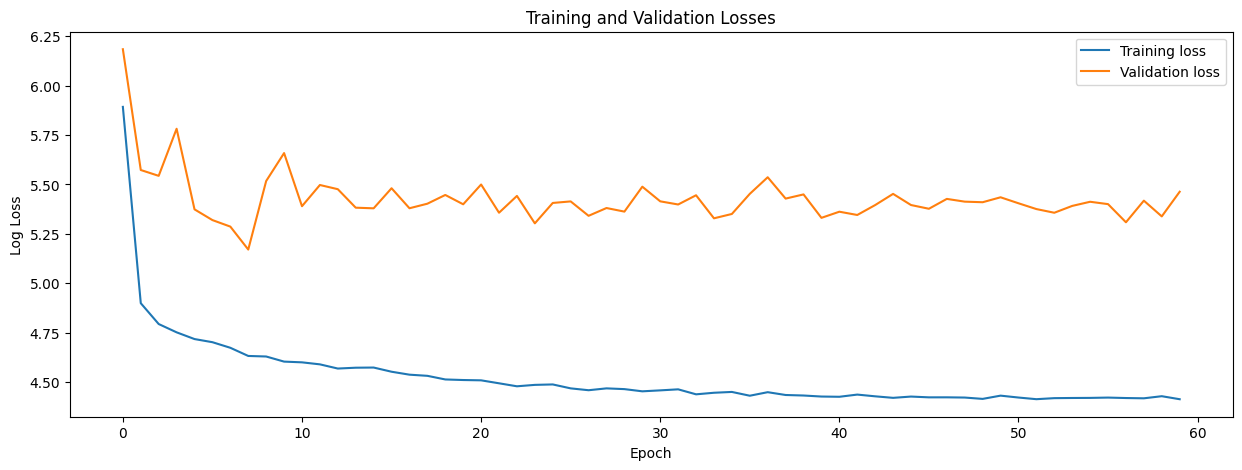

In [8]:
# TRAINING LOOP


#create datasets and loaders
batch_size = int(128)
print(f"Batch size: {batch_size}")
train_dataset = Ice_graph_dataset(train_graph_list, normalize=False,z_score=False)
val_dataset = Ice_graph_dataset(val_graph_list, normalize=False,z_score=False)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

e_graph = next(iter(train_dataset))[0] #just to get the num_features
num_features1 = e_graph.x.shape[-1]  # Node feature dimension
v_graph = next(iter(train_dataset))[1] #just to get the num_features
num_features2 = v_graph.x.shape[-1]  # Node feature dimension

##LAYERS
hidden_channels = (
    [num_features1*3,num_features1*3,num_features1*3,10],
    [num_features1*3,num_features1*3,num_features1*3,10]
    )
num_classes = e_graph.y[0].shape[0] # trajectory lenght *2, since we have x,y.

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GCNN_2G(num_features1,num_features2, hidden_channels, num_classes,dropout=0.5).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=0.4)
scheduler = ExponentialLR(optimizer, gamma=0.9)
#loss = nn.L1Loss()
loss = CustomIceLoss(A=0,B=1,C=0,step=nextsim.step,d_time=nextsim.d_time)
num_epochs = 60

#trianing loop
training_losses = []
validation_losses = []
for epoch in range(num_epochs):
    training_loss = process_dataloader(model, train_dataloader, device, optimizer, loss,gradient_clip=None)
    training_losses.append(training_loss)

    if epoch % 5 == 0:
        print(f"Epoch {epoch+1}/{num_epochs}")
        print(f"\tAverage Training Loss: {training_loss:.8f}")

    val_loss = process_dataloader(model, val_dataloader, device, criterion=loss)
    validation_losses.append(val_loss)

    if epoch % 5 == 0:
        print(f"\tAverage Validation Loss: {val_loss:.8f}")

    scheduler.step() if scheduler else None
    


#plot losses curve
plt.figure(figsize=(15,5))
plt.plot(np.log(training_losses[:]),label='Training loss')
plt.plot(np.log(validation_losses[:]),label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Log Loss')
plt.title('Training and Validation Losses')
plt.legend()
plt.show()

In [14]:
#define metrics
mse =  nn.MSELoss(reduction='none')
mae = nn.L1Loss(reduction='none')

lossess = []
targets = []
predictions = []
init_coords = []
for graph in val_dataloader:
        e_g,v_g = graph[0].to(device),graph[1].to(device)
        output = model(e_g,v_g).cpu().detach().squeeze()
        target = e_g.y[0].cpu().detach()
        targets.append(target) #target
        predictions.append(output) #predicted
        init_coords.append(e_g.y[-1])#initial coords

targets = torch.cat(targets[:-1])
predictions = torch.cat(predictions[:-1])
init_coords = torch.cat(init_coords[:-1])

rmse_position,mae_vel_norm,angles,target_vel,predicted_vel = compute_metrics(targets,predictions,init_coords,predict_vel,step=nextsim.step)



In [ ]:
(torch.sqrt(targets[:,0]**2 + targets[:,1]**2).mean())

tensor(0.0841)

In [2]:
target_vel = target_vel.squeeze()
predicted_vel = predicted_vel.squeeze()

position_absolute_mean = float(torch.mean(rmse_position))
velocity_absolute_mean = float(torch.mean(mae_vel_norm))
angle_absolute_mean = float(torch.mean(angles))

#get relative errors
u_error = (target_vel[0,:] - predicted_vel[0,:])/target_vel[1,:] #relative error
v_error = (target_vel[1,:] - predicted_vel[1,:])/target_vel[1,:]

#compute target velocitity norm
target_vel_norm = velocity_norm(target_vel)


#plot error scatter
plt.figure(figsize=(15,10))
plt.scatter(u_error,v_error, c=target_vel_norm,alpha=.3,cmap='viridis',s=5)
#center at 00 
plt.axhline(0, color='black',linewidth=.5)
plt.axvline(0, color='black',linewidth=.5)
zoom = 4
plt.xlim(-zoom,zoom)
plt.ylim(-zoom,zoom)
plt.colorbar(label='Velocity norm (m/s)')
plt.xlabel('u error')
plt.ylabel('v error')
plt.title(f'Relative error scatter plot\n RMSE position: {position_absolute_mean:.4f} m, MAE velocity norm: {velocity_absolute_mean:.4f} m/s, Mean angle: {angle_absolute_mean:.2f} degrees')
plt.show()

NameError: name 'target_vel' is not defined

In [1]:
print(f"RMSE position shape: {rmse_position.shape}, MAE velocity shape: {mae_vel_norm.shape}, Angle shape: {angles.shape}")

position_spatial_mean = torch.mean(rmse_position,dim=1)
velocity_spatial_mean = torch.mean(mae_vel_norm,dim=0)
angle_spatial_mean = torch.mean(angles, dim=0)

position_absolute_mean = float(torch.mean(rmse_position))
velocity_absolute_mean = float(torch.mean(mae_vel_norm))
angle_absolute_mean = float(torch.mean(angles))

position_std = float(torch.std(rmse_position))
velocity_std = float(torch.std(mae_vel_norm))
angle_std = float(torch.std(angles))


fig, axs = plt.subplots(3,1,figsize=(12,24))

#position
axs[0].scatter(selected_graph['x'],selected_graph['y'],c='grey', s= 1 ,marker='.',linewidths=.7,alpha=.5)
im = axs[0].scatter(init_coords[:,0],init_coords[:,1],c=np.clip(position_spatial_mean,0,position_absolute_mean+5*position_std),s=3, cmap='viridis')
#axs[0].set_xlim([-0.8e6, 0.8e6])
#axs[0].set_ylim([-0.75e6, 0.75e6])
axs[0].set_title("Root mean squared Error: "+str(position_absolute_mean)[:7]+" meters")
plt.colorbar( im, label="Error in meters")

#velocity
im = axs[1].scatter(selected_graph['x'],selected_graph['y'],c='grey', s= 1 ,marker='.',linewidths=.7,alpha=.5)
im = axs[1].scatter(init_coords[:,0],init_coords[:,1],c=np.clip(velocity_spatial_mean,0,velocity_absolute_mean+5*velocity_std),s=3, cmap='viridis')
#axs[1].set_xlim([-0.8e6, 0.8e6])
#axs[1].set_ylim([-0.75e6, 0.75e6])
axs[1].set_title("Mean absolute error: "+str(velocity_absolute_mean)[:7]+" m/s")
plt.colorbar( im, label="Error in m/s")

#angle
im = axs[2].scatter(selected_graph['x'],selected_graph['y'],c='grey', s= 1 ,marker='.',linewidths=.7,alpha=.5)
im = axs[2].scatter(init_coords[:,0],init_coords[:,1],c=np.clip(angle_spatial_mean,0,angle_absolute_mean+5*angle_std),s=3, cmap='viridis')
#axs[2].set_xlim([-0.8e6, 0.8e6])
#axs[2].set_ylim([-0.75e6, 0.75e6])
axs[2].set_title("Mean absolute error: "+str(angle_absolute_mean)[:7]+" degrees")
plt.colorbar( im, label="Angle in degrees")




NameError: name 'rmse_position' is not defined

Text(0.5, 0, 'Angle degrees)')

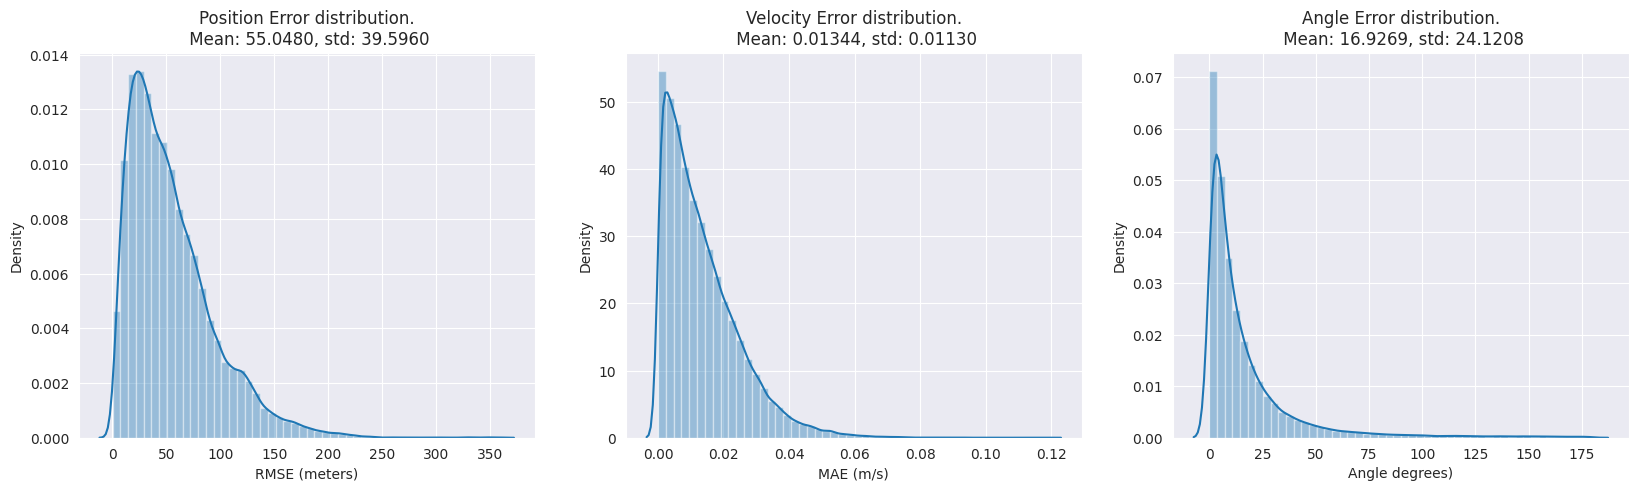

In [14]:
#ignore warnings
import warnings
warnings.filterwarnings('ignore')

#error data distributions
sns.set_style('darkgrid')

fig, axs = plt.subplots(1,3,figsize=(20,5))

sns.distplot(ax=axs[0],a=position_spatial_mean,bins=50)
axs[0].set_title(f"Position Error distribution.\n Mean: {str(position_absolute_mean)[:7]}, std: {str(position_std)[:7]}")
axs[0].set_xlabel("RMSE (meters)")

sns.distplot(ax=axs[1],a=velocity_spatial_mean,bins=50)
axs[1].set_title(f"Velocity Error distribution.\n Mean: {str(velocity_absolute_mean)[:7]}, std: {str(velocity_std)[:7]}")
axs[1].set_xlabel("MAE (m/s)")

sns.distplot(ax=axs[2],a=angle_spatial_mean,bins=50)
axs[2].set_title(f"Angle Error distribution.\n Mean: {str(angle_absolute_mean)[:7]}, std: {str(angle_std)[:7]}")
axs[2].set_xlabel("Angle degrees)")




100%|██████████| 3000/3000 [00:07<00:00, 380.38it/s]


Total time:  7.8894500732421875
Neighbours time 41.3734 %
Trajectories time 7.0571 %
Element node features time 3.7285 %
Element edge features time 8.4937 %
Element edge distances time 3.6658 %
Vertex node features time 2.5776 %
Vertex edge features time 23.2755 %
Vertex edge distances time 3.9577 %


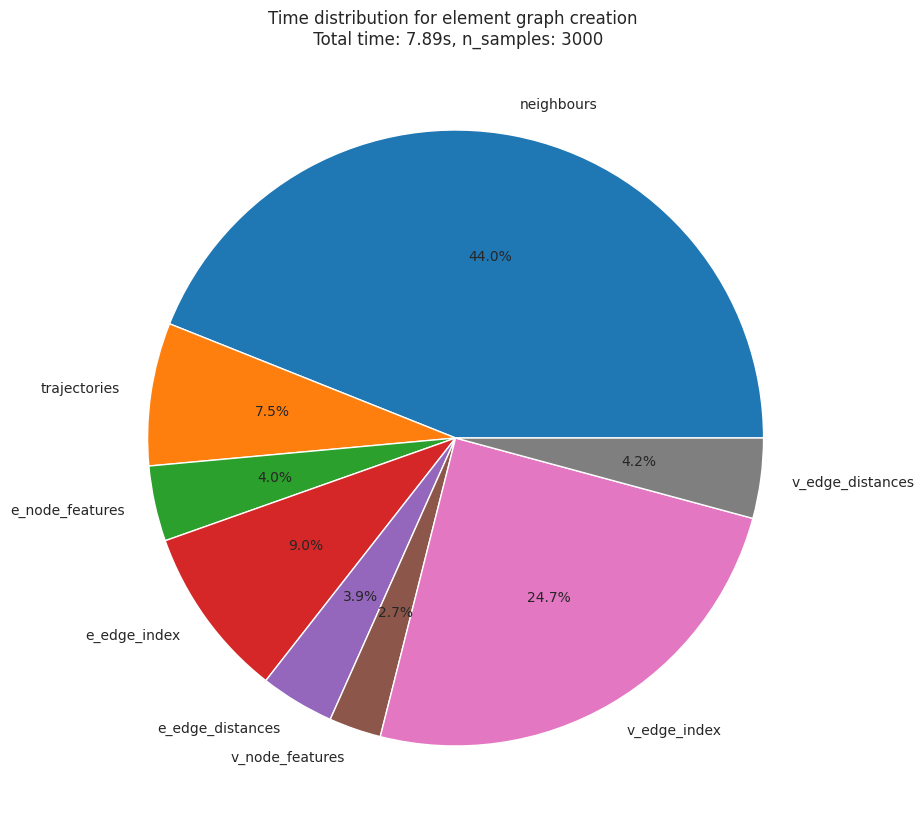

In [12]:
## TIMMINGS...
import time

times = {
    "neighbours":[],
    "trajectories":[],
    "e_node_features":[],
    "e_edge_index":[],
    "e_edge_distances":[],
    "v_node_features":[],
    "v_edge_index":[],
    "v_edge_distances":[],
}

total_time = time.time()


target_iter:int = 1
e_features: list[str] = ['Damage', 'Concentration', 'Thickness', 'M_wind_x', 'M_wind_y', 'M_ocean_x', 'M_ocean_y', 'x', 'y']
v_features: list[str] = ['M_wind_x', 'M_wind_y', 'M_ocean_x', 'M_ocean_y', 'x', 'y']
include_vertex:bool = True

for sample in tqdm(samples_train):

    vertex_i= sample

    element_data = nextsim.get_item(time_index,elements=True)
    vertex_data = nextsim.get_item(time_index,elements=False)
    vertex_index= np.where(vertex_data['i']==vertex_i)[0]

    #get the neighbours

    t_neighbours = time.time()
    e_neighbours,v_neighbours = nextsim.compute_vertex_neighbourhood(vertex_index=vertex_index,time_index=time_index,return_vertex=include_vertex)
    times["neighbours"].append(time.time()-t_neighbours)

    t_trajectories = time.time()
    #get target coordinates
    target = nextsim.get_vertex_trajectories(time_index,vertex_i=vertex_i,iter=target_iter+1)

    if len(target.shape)==1 or target.shape[0] != target_iter+1:
        print("miss")    #skip vertexs / elements that disapear
    target = target.flatten().to(torch.float32)/1000 #tokm

    #store initial coordinates for visulisazion
    vertex_idx = vertex_index
    x_center = vertex_data['x'][vertex_idx]
    y_center = vertex_data['y'][vertex_idx]
    element_coords = np.array([x_center,y_center])/1000 #tokm
    y = [target,element_coords]
    times["trajectories"].append(time.time()-t_trajectories)


    t_e_node_features = time.time()
    #get node features
    node_features, features_indeces = nextsim._Ice_graph__get_node_features(element_data,e_features,e_neighbours)
    times["e_node_features"].append(time.time()-t_e_node_features)

    t_e_edge_features = time.time()
    #get edge features
    edge_index = nextsim._Ice_graph__get_element_edge_index(element_data,e_neighbours,edge_conectivity=True)
    times["e_edge_index"].append(time.time()-t_e_edge_features)

    t_e_edge_distances = time.time()
    #get edge distances and node positions
    edge_dist,positions = nextsim._Ice_graph__compute_edge_distances(feature_indeces=features_indeces,node_features=node_features,edge_index=edge_index)
    times["e_edge_distances"].append(time.time()-t_e_edge_distances)
    #Now we can create our torch-geometric graph using the "Data" class
    e_graph = Data(x=node_features, edge_index=edge_index, edge_attr=edge_dist,pos=positions, y=y)
    v_graph = None

    if include_vertex:
        t_v_node_features = time.time()
        #get node features
        node_features, features_indeces = nextsim._Ice_graph__get_node_features(vertex_data,v_features,v_neighbours)
        times["v_node_features"].append(time.time()-t_v_node_features)

        t_v_edge_features = time.time()
        #get edge features
        edge_index = nextsim._Ice_graph__get_vertex_edge_index(vertex_neighbours=v_neighbours,triangles=element_data['t'][e_neighbours])
        times["v_edge_index"].append(time.time()-t_v_edge_features)

        t_v_edge_distances = time.time()
        #get edge distances and node positions
        edge_dist,positions = nextsim._Ice_graph__compute_edge_distances(feature_indeces=features_indeces,node_features=node_features,edge_index=edge_index)
        times["v_edge_distances"].append(time.time()-t_v_edge_distances)

        #Now we can create our torch-geometric graph using the "Data" class
        v_graph = Data(x=node_features, edge_index=edge_index, edge_attr=edge_dist,pos=positions, y=y)

    v_g = v_graph
    e_g = e_graph

total_time = time.time()-total_time

print("Total time: ",total_time)
print(f"Neighbours time {100*np.sum(times['neighbours'])/total_time:.4f} %")
print(f"Trajectories time {100*np.sum(times['trajectories'])/total_time:.4f} %")
print(f"Element node features time {100*np.sum(times['e_node_features'])/total_time:.4f} %")
print(f"Element edge features time {100*np.sum(times['e_edge_index'])/total_time:.4f} %")
print(f"Element edge distances time {100*np.sum(times['e_edge_distances'])/total_time:.4f} %")
print(f"Vertex node features time {100*np.sum(times['v_node_features'])/total_time:.4f} %")
print(f"Vertex edge features time {100*np.sum(times['v_edge_index'])/total_time:.4f} %")
print(f"Vertex edge distances time {100*np.sum(times['v_edge_distances'])/total_time:.4f} %")


#plot time distribution as a pie chart
plt.figure(figsize=(10,10))
plt.pie([np.sum(times[key]) for key in times.keys()],labels=times.keys(),autopct='%1.1f%%')
plt.title(f"Time distribution for element graph creation \n Total time: {total_time:.2f}s, n_samples: {len(samples_train)}")
plt.show()

